In [1]:
import cv2
from PIL import Image
import random
import os, glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn

from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn.functional as F

from tqdm.autonotebook import tqdm

In [3]:
device = 'cuda'
batch_size = 32
num_workers = 4
lr = 1e-3
momentum = 0.9
weight_decay = 1e-5
epoch = 20
n_steps = 10000

In [4]:
from torch.utils.data import DataLoader, RandomSampler



data_transforms = {
    'train': transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomChoice([
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
        transforms.RandomResizedCrop(128),
        transforms.RandomAffine(
            degrees=15, translate=(0.2, 0.2),
            scale=(0.8, 1.2), shear=15, resample=Image.BILINEAR)
    ]),
    transforms.ToTensor(),
    transforms.Normalize((0.4452, 0.4457, 0.4464), (0.2592, 0.2596, 0.2600)),
]),
    'test': transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.4452, 0.4457, 0.4464), (0.2592, 0.2596, 0.2600)),
])
}


train_dataset = datasets.ImageFolder('dataset/train', transform=data_transforms['train'])
# test_dataset = datasets.ImageFolder('Linnaeus 5 128X128/test', transform=data_transforms['test'])

sampler = RandomSampler(train_dataset,
                        replacement=True,
                        num_samples=batch_size * n_steps)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              sampler=sampler, num_workers=num_workers, shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
#                              shuffle=False, num_workers=num_workers)


print(len(train_dataset)) # b , 3, 64, 64
# print(len(test_dataset))

270


/app/share/anaconda3/envs/pytorch-1.10/lib/python3.9/site-packages/torchvision/transforms/transforms.py:1361: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


Size of train set: 270
Input shape: torch.Size([3, 128, 128])
Label: 0


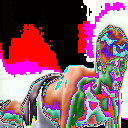

In [5]:
# Let's take a look at train dataset
print(f"Size of train set: {len(train_dataset)}")
index = 0
x, y = train_dataset[index]
print(f"Input shape: {x.shape}")
print(f"Label: {y}")

transforms.functional.to_pil_image(x)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(512, 1024, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(1024, 2048, 4, 2, 1),
            nn.ReLU(True),
            nn.Flatten()
        )
        
        n_channels = self.encoder(torch.empty(1, 3, 128,128)).size(-1)
        
        
        self.enc_out = nn.Sequential(
            nn.Linear(n_channels, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 256),
            nn.ReLU(True),
            nn.Linear(256, latent_dim * 2))
        

        self.decoder = nn.Sequential(
                    nn.Linear(latent_dim, 256),
                    nn.ReLU(True),
                    nn.Linear(256, 1024),
                    nn.ReLU(True),
                    nn.Linear(1024, 2048),
                    nn.ReLU(True),
                    nn.Linear(2048, 4096),
                    nn.ReLU(True),
                    nn.Unflatten(1, (4096, 1, 1)),  # 1x1x2048로 reshape
                    nn.ConvTranspose2d(4096, 2048, 4, 2, 1),
                    nn.ReLU(True),
                    nn.ConvTranspose2d(2048, 1024, 4, 2, 1),
                    nn.ReLU(True),
                    nn.ConvTranspose2d(1024, 512, 4, 2, 1),
                    nn.ReLU(True),
                    nn.ConvTranspose2d(512, 256, 4, 2, 1),
                    nn.ReLU(True),
                    nn.ConvTranspose2d(256, 128, 4, 2, 1),
                    nn.ReLU(True),
                    nn.ConvTranspose2d(128, 64, 4, 2, 1),
                    nn.ReLU(True),
                    nn.ConvTranspose2d(64, 3, 4, 2, 1),
                    nn.Sigmoid()
                )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x_enc = self.encoder(x)
        mu, logvar = self.enc_out(x_enc).chunk(2, dim=1)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)

        return x_recon, mu, logvar

# 모델 학습
model = VAE(latent_dim=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for i, (x, _) in enumerate(train_dataloader):
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar = model(x)
        loss = torch.mean(torch.pow(x - x_recon, 2)) + torch.mean(torch.exp(logvar) + mu**2 - 1 - logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, total_loss / len(train_dataloader)))


Epoch [1/10], Loss: 1.5686


In [ ]:

model.load_state_dict(torch.load('vae_model.pt'))  # 모델 경로와 파일 이름에 맞게 수정



In [ ]:
# 이상 탐지 수행
model.eval()

threshold = 0.01  # 이상치 판별 임계값

with torch.no_grad():
    anomaly_count = 0
    for data, _ in test_loader:
        data = data.to(device)
        x_hat, mean, log_var = model(data)
        loss = nn.functional.binary_cross_entropy(x_hat, data, reduction='mean')
        if loss > threshold:
            anomaly_count += 1

print("이상치 개수:", anomaly_count)